# Set up

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

2024-03-04 00:57:35.684436: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-04 00:57:35.713348: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-04 00:57:35.813569: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-04 00:57:35.813623: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-04 00:57:35.829130: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

# Vanishing/Exploding Gradients Problem

In [3]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

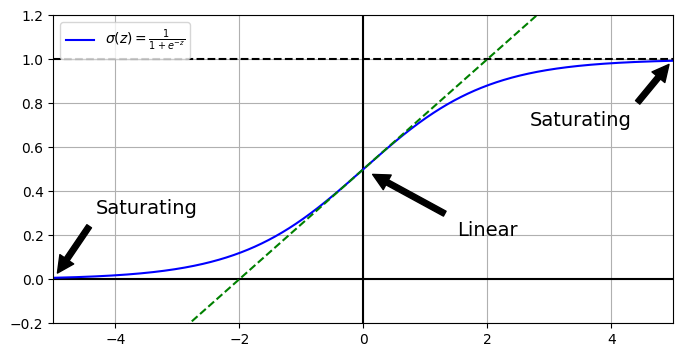

In [4]:
z = np.linspace(-5, 5, 1000)

plt.figure(figsize=(8, 4))
plt.plot([-5, 5], [0, 0], "k-")
plt.plot([-5, 5], [1, 1], "k--")
plt.plot([0, 0], [-0.2, 1.2], "k-")
plt.plot(z, sigmoid(z), "b-", label=r"$\sigma(z) = \frac{1}{1 + e^{-z}}$")
plt.plot([-5, 5], [-3 / 4, 7 / 4], "g--")
props = dict(facecolor="black", shrink=0.1)
plt.annotate(
    "Saturating",
    xytext=(3.5, 0.7),
    xy=(5, 1),
    arrowprops=props,
    fontsize=14,
    ha="center",
)
plt.annotate(
    "Saturating",
    xytext=(-3.5, 0.3),
    xy=(-5, 0),
    arrowprops=props,
    fontsize=14,
    ha="center",
)
plt.annotate(
    "Linear", xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center"
)
plt.grid()
plt.legend(loc="upper left")
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

## Xavier and He initialization                

You can switch to your desired initialization by setting the `kernel_initializer` hyperparameter.

In [5]:
dense = tf.keras.layers.Dense(50, activation="relu", kernel_initializer="he_normal")

If you want to use He initialization with a uniform distribution and based on $fan_{avg}$ instead of $fan_{in}$, you can use the `VarianceScaling` initializer.

In [6]:
he_avg_init = tf.keras.initializers.VarianceScaling(
    scale=2.0, mode="fan_avg", distribution="uniform"
)
dense = tf.keras.layers.Dense(50, activation="sigmoid", kernel_initializer=he_avg_init)

## Non-saturating Activation Functions

### Leaky ReLU

In [7]:
def leaky_relu(z, alpha):
    return np.maximum(z, alpha * z)

(-5.0, 5.0, -1.0, 4.0)

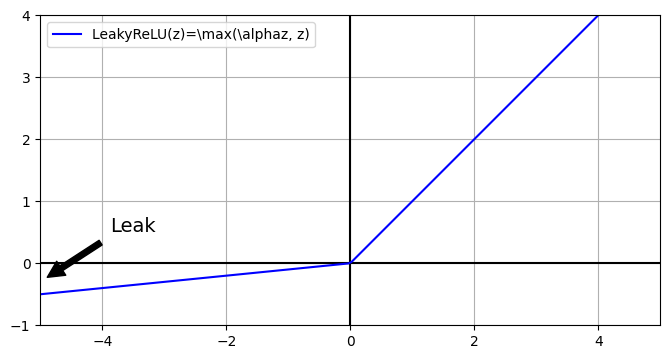

In [8]:
z = np.linspace(-5, 5, 200)
plt.figure(figsize=((8, 5)))
plt.plot([0, 0], [-5, 5], "k-")
plt.plot([-5, 5], [0, 0], "k-")
plt.plot(z, leaky_relu(z, 0.1), "b-", label=r"LeakyReLU(z)=\max(\alphaz, z)")
props = dict(facecolor="black", shrink=0.1)
plt.annotate(
    "Leak",
    xy=(-5, -0.3),
    xytext=(-3.5, 0.5),
    arrowprops=props,
    fontsize=14,
    ha="center",
)
plt.gca().set_aspect("equal")
plt.grid()
plt.legend()
plt.axis([-5, 5, -1, 4])

In [9]:
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)
dense = tf.keras.layers.Dense(50, activation=leaky_relu, kernel_initializer="he_normal")

In [10]:
model = tf.keras.Sequential(
    [
        # some layers
        tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # no activation
        tf.keras.layers.LeakyReLU(alpha=0.2),  # activation as a separate layer
        # more layers
    ]
)

### ELU and SELU

- We reimplement the SELU using the coefficient in the paper. <br>
- Note that `erfc(x)` function stands for Complementary Error Function, which is defined as `1-rfc(x)`, where `erf(x)` is the Error Function.<br>
- The formula of `erf()` is:
$$\text{erf}(x) = \frac{2}{\sqrt{\pi}} \int_0^x e^{-t^2}$$
- `erfc(x)` is related to the cumulative distribution function (CDF) of a standard normal distribution:
$$erfc\left(\frac{x}{\sqrt{2}}\right)=2 \times CDF(-x) $$

In [11]:
from scipy.special import erfc

alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e**2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    )
    ** (-1 / 2)
)


def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)


def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

In [12]:
scale_0_1

1.0507009873554805

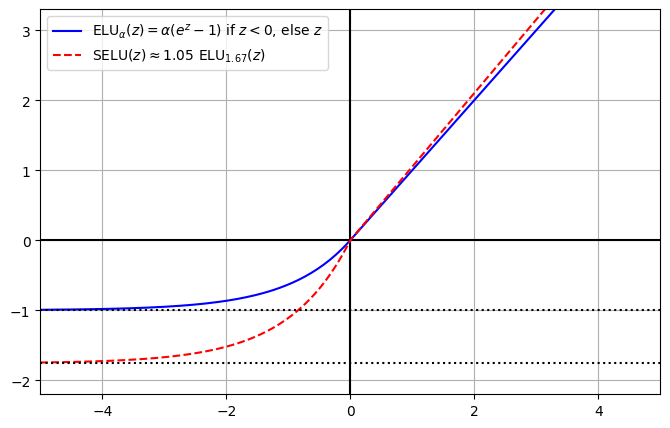

In [13]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(8, 5))
plt.plot([0, 0], [-5, 5], "k-")
plt.plot([-5, 5], [0, 0], "k-")
plt.plot(z, elu(z), "b-", label=r"ELU$_\alpha(z)=\alpha(e^z-1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", label=r"SELU$(z)\approx1.05 \ $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [-1, -1], "k:")
plt.plot([-5, 5], [-scale_0_1 * alpha_0_1, -scale_0_1 * alpha_0_1], "k:")
plt.legend()
plt.grid()
plt.axis([-5, 5, -2.2, 3.3])
plt.show()

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer, and use He initialization.

In [14]:
dense = tf.keras.layers.Dense(50, activation="elu", kernel_initializer="he_normal")

Similarly, using SELU is straightforward.

In [15]:
dense = tf.keras.layers.Dense(50, activation="selu", kernel_initializer="lecun_normal")

**Extra material - an example of a self-regularized network using SELU**

Here we create a neural network for Fashion MNIST with 100 hidden layers, using the SELU activation function.

In [16]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(100):
    model.add(
        tf.keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal")
    )
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [17]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    metrics=["accuracy"],
)

Now let's train it. Do not forget to scale the input to mean 0 and standard deviation 1.

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255.0, X_valid / 255.0, X_test / 255.0

In [3]:
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

In [4]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [21]:
history = model.fit(
    X_train_scaled, y_train, epochs=5, validation_data=(X_valid_scaled, y_valid)
)

Epoch 1/5
1719/1719 [==============================] - 20s 10ms/step - loss: 1.0957 - accuracy: 0.5914 - val_loss: 0.9874 - val_accuracy: 0.6664
Epoch 2/5
1719/1719 [==============================] - 17s 10ms/step - loss: 0.7501 - accuracy: 0.7355 - val_loss: 0.6836 - val_accuracy: 0.7628
Epoch 3/5
1719/1719 [==============================] - 16s 10ms/step - loss: 0.6817 - accuracy: 0.7560 - val_loss: 0.6188 - val_accuracy: 0.7826
Epoch 4/5
1719/1719 [==============================] - 17s 10ms/step - loss: 0.5948 - accuracy: 0.7906 - val_loss: 0.5590 - val_accuracy: 0.8046
Epoch 5/5
1719/1719 [==============================] - 16s 9ms/step - loss: 0.5511 - accuracy: 0.8072 - val_loss: 0.5272 - val_accuracy: 0.8108


The network managed to learn, despite how deep it is. Now look at what happened if we try to use the ReLU activation function instead.

In [22]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(100):
    model.add(
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal")
    )
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [23]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    metrics=["accuracy"],
)

In [24]:
history = model.fit(
    X_train_scaled, y_train, epochs=5, validation_data=(X_valid_scaled, y_valid)
)

Epoch 1/5
1719/1719 [==============================] - 18s 9ms/step - loss: 2.0039 - accuracy: 0.2035 - val_loss: 2.9914 - val_accuracy: 0.1492
Epoch 2/5
1719/1719 [==============================] - 15s 8ms/step - loss: 1.5403 - accuracy: 0.3466 - val_loss: 1.2291 - val_accuracy: 0.4670
Epoch 3/5
1719/1719 [==============================] - 15s 9ms/step - loss: 1.1385 - accuracy: 0.5264 - val_loss: 1.2218 - val_accuracy: 0.4460
Epoch 4/5
1719/1719 [==============================] - 15s 9ms/step - loss: 0.9385 - accuracy: 0.6131 - val_loss: 0.8187 - val_accuracy: 0.6992
Epoch 5/5
1719/1719 [==============================] - 15s 9ms/step - loss: 0.8151 - accuracy: 0.6812 - val_loss: 0.8296 - val_accuracy: 0.6750


Not so great, we suffer from the vanishing/exploding gradients problem.

### GELU, Swish and Mish

In [25]:
def swish(z, beta=1):
    return z * sigmoid(beta * z)


def approx_gelu(z):
    return swish(z, beta=1.702)


def softplus(z):
    return np.log(np.exp(z) + 1)


def mish(z):
    return z * np.tanh(softplus(z))

Text(0.5, 0, 'z')

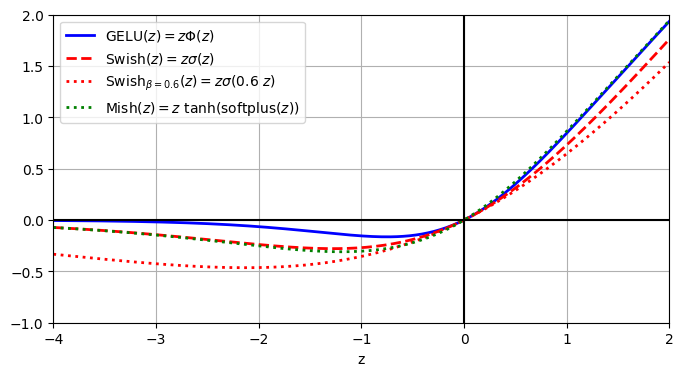

In [26]:
z = np.linspace(-4, 2, 200)

beta = 0.6
plt.figure(figsize=(8, 4))
plt.plot(z, approx_gelu(z), "b-", linewidth=2, label=r"GELU$(z)=z\Phi(z)$")
plt.plot(z, swish(z), "r--", linewidth=2, label=r"Swish$(z)=z\sigma(z)$")
plt.plot(
    z,
    swish(z, 0.6),
    "r:",
    linewidth=2,
    label=rf"Swish$_{{\beta={beta}}}(z)=z\sigma({beta} \ z)$",
)
plt.plot(z, mish(z), "g:", linewidth=2, label=r"Mish$(z)=z \ \tanh($softplus$(z))$")
plt.plot([-5, 5], [0, 0], "k-")
plt.plot([0, 0], [-5, 5], "k-")
plt.legend()
plt.grid()
plt.axis([-4, 2, -1, 2])
plt.gca().set_aspect("equal")
plt.xlabel("z")

# Batch Normalization

In [27]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [28]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)

In this tiny example, just two hidden layers batch normalization is unlikely to make a huge impact, but ofr deeper network it can have a tremendous difference.

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (Batch  (None, 784)               3136      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 batch_normalization_1 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Bat  (None, 100)               4

Let's look at the parameters of the first BN layer:

In [30]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [31]:
# Extra code - just to verify that the model works
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"]
)
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5547 - accuracy: 0.8078 - val_loss: 0.4069 - val_accuracy: 0.8514
Epoch 2/2
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4064 - accuracy: 0.8557 - val_loss: 0.3620 - val_accuracy: 0.8646


In [32]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [33]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)

In [34]:
# Extra code - just to verify that the model works
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"]
)
model.fit(X_train, y_train, epochs=1, validation_data=(X_valid, y_valid))

1719/1719 [==============================] - 5s 3ms/step - loss: 0.6013 - accuracy: 0.7984 - val_loss: 0.4250 - val_accuracy: 0.8474


## Gradient Clipping

All `tf.keras.optimizers` accept `clipnorm` or `clipvalue` argument.

In [35]:
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

In [36]:
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

## Reusing Pretrained Layers

### Transfer Learning with Keras

In [37]:
sandal_idx = class_names.index("Pullover")
shirt_idx = class_names.index("T-shirt/top")


def split_dataset(X, y):
    # Here, as the model B contains only 2 classes, we assume the positive class is the sandal class and the negative class is the shirt class
    y_for_B = (y == sandal_idx) | (y == shirt_idx)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == sandal_idx).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([sandal_idx, shirt_idx]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # reorder class ids for A
    return (X[~y_for_B], y_A), (X[y_for_B], y_B)


(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [38]:
tf.random.set_seed(42)
model_A = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="softmax"),
    ]
)
model_A.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    metrics=["accuracy"],
)
history = model.fit(
    X_train_A, y_train_A, epochs=20, validation_data=(X_valid_A, y_valid_A)
)
model_A.save("my_model_A")

Epoch 1/20
1376/1376 [==============================] - 4s 3ms/step - loss: 0.5693 - val_loss: 0.2986
Epoch 2/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.2970 - val_loss: 0.2598
Epoch 3/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.2633 - val_loss: 0.2499
Epoch 4/20
1376/1376 [==============================] - 4s 3ms/step - loss: 0.2393 - val_loss: 0.2395
Epoch 5/20
1376/1376 [==============================] - 4s 3ms/step - loss: 0.2229 - val_loss: 0.2311
Epoch 6/20
1376/1376 [==============================] - 3s 3ms/step - loss: 0.2126 - val_loss: 0.2281
Epoch 7/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.1997 - val_loss: 0.2227
Epoch 8/20
1376/1376 [==============================] - 3s 3ms/step - loss: 0.1908 - val_loss: 0.2269
Epoch 9/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.1823 - val_loss: 0.2190
Epoch 10/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.173

INFO:tensorflow:Assets written to: my_model_A/assets


In [39]:
tf.random.set_seed(42)
model_B = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model_B.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    metrics=["accuracy"],
)
history = model_B.fit(
    X_train_B, y_train_B, epochs=20, validation_data=(X_valid_B, y_valid_B)
)
model_B.evaluate(X_test_B, y_test_B)

Epoch 1/20
7/7 [==============================] - 0s 20ms/step - loss: 0.6891 - accuracy: 0.4450 - val_loss: 0.6494 - val_accuracy: 0.4946
Epoch 2/20
7/7 [==============================] - 0s 7ms/step - loss: 0.6455 - accuracy: 0.4550 - val_loss: 0.6154 - val_accuracy: 0.5193
Epoch 3/20
7/7 [==============================] - 0s 8ms/step - loss: 0.6100 - accuracy: 0.5450 - val_loss: 0.5869 - val_accuracy: 0.6677
Epoch 4/20
7/7 [==============================] - 0s 8ms/step - loss: 0.5794 - accuracy: 0.7100 - val_loss: 0.5673 - val_accuracy: 0.8071
Epoch 5/20
7/7 [==============================] - 0s 8ms/step - loss: 0.5586 - accuracy: 0.8250 - val_loss: 0.5504 - val_accuracy: 0.8625
Epoch 6/20
7/7 [==============================] - 0s 7ms/step - loss: 0.5400 - accuracy: 0.8700 - val_loss: 0.5357 - val_accuracy: 0.8942
Epoch 7/20
7/7 [==============================] - 0s 7ms/step - loss: 0.5235 - accuracy: 0.9200 - val_loss: 0.5232 - val_accuracy: 0.9021
Epoch 8/20
7/7 [=================

[0.4078425467014313, 0.9315000176429749]

Model B reached 93.80% accuracy on the test set. Now let's try reusing the pretrained model A.

In [40]:
model_A = tf.keras.models.load_model("my_model_A")
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

Note that `model_B_on_A` and `model_A` actually share layers now, so if we train one, it will update both models. If we want to avoid this, we need to build `model_B_on_A` on top of a *clone* of `model_A`.

In [41]:
tf.random.set_seed(42)

model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [42]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(
    loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)

In [43]:
history = model_B_on_A.fit(
    X_train_B, y_train_B, epochs=4, validation_data=(X_valid_B, y_valid_B)
)

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(
    loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)
history = model_B_on_A.fit(
    X_train_B, y_train_B, epochs=16, validation_data=(X_valid_B, y_valid_B)
)

Epoch 1/4


7/7 [==============================] - 0s 21ms/step - loss: 0.8643 - accuracy: 0.5400 - val_loss: 0.8875 - val_accuracy: 0.4946
Epoch 2/4
7/7 [==============================] - 0s 7ms/step - loss: 0.8562 - accuracy: 0.5300 - val_loss: 0.8795 - val_accuracy: 0.4886
Epoch 3/4
7/7 [==============================] - 0s 7ms/step - loss: 0.8496 - accuracy: 0.5200 - val_loss: 0.8733 - val_accuracy: 0.4886
Epoch 4/4
7/7 [==============================] - 0s 7ms/step - loss: 0.8440 - accuracy: 0.5150 - val_loss: 0.8667 - val_accuracy: 0.4817
Epoch 1/16
7/7 [==============================] - 0s 26ms/step - loss: 0.8104 - accuracy: 0.5100 - val_loss: 0.7814 - val_accuracy: 0.4402
Epoch 2/16
7/7 [==============================] - 0s 9ms/step - loss: 0.7435 - accuracy: 0.5100 - val_loss: 0.7330 - val_accuracy: 0.4590
Epoch 3/16
7/7 [==============================] - 0s 8ms/step - loss: 0.7026 - accuracy: 0.5400 - val_loss: 0.6991 - val_accuracy: 0.5173
Epoch 4/16
7/7 [==============================

So what's the final verdict?

In [44]:
model_B_on_A.evaluate(X_test_B, y_test_B)

 1/63 [..............................] - ETA: 1s - loss: 0.4759 - accuracy: 0.8125

63/63 [==============================] - 0s 1ms/step - loss: 0.4565 - accuracy: 0.8895


[0.4564748704433441, 0.8895000219345093]

Well, to our surprise, the model's performance actually drops! The full explanation is in the note.md. 

# Faster Optimizers

In [5]:
# Build some help function to test an optimizer on Fashion MNIST


def build_model(seed: int = 42):
    tf.random.set_seed(42)
    return tf.keras.Sequential(
        [
            tf.keras.layers.Flatten(input_shape=[28, 28]),
            tf.keras.layers.Dense(
                100, activation="relu", kernel_initializer="he_normal"
            ),
            tf.keras.layers.Dense(
                100, activation="relu", kernel_initializer="he_normal"
            ),
            tf.keras.layers.Dense(
                100, activation="relu", kernel_initializer="he_normal"
            ),
            tf.keras.layers.Dense(100, activation="softmax"),
        ]
    )


def build_and_train_model(
    optimizer: tf.keras.optimizers.Optimizer,
) -> tf.keras.callbacks.History:
    model = build_model()
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"],
    )
    return model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

In [46]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [47]:
history_sgd = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.7905 - accuracy: 0.7351 - val_loss: 0.5172 - val_accuracy: 0.8188
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4949 - accuracy: 0.8279 - val_loss: 0.4769 - val_accuracy: 0.8284
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4445 - accuracy: 0.8444 - val_loss: 0.4278 - val_accuracy: 0.8476
Epoch 4/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4141 - accuracy: 0.8560 - val_loss: 0.3979 - val_accuracy: 0.8586
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3906 - accuracy: 0.8625 - val_loss: 0.3856 - val_accuracy: 0.8616
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3758 - accuracy: 0.8675 - val_loss: 0.3772 - val_accuracy: 0.8638
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3578 - accuracy: 0.8715 - val_loss: 0.3762 - val_accuracy:

## Momentum optimization

In [48]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [49]:
history_momentum = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.8072 - accuracy: 0.7411 - val_loss: 0.5116 - val_accuracy: 0.8228
Epoch 2/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4864 - accuracy: 0.8303 - val_loss: 0.4562 - val_accuracy: 0.8356
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4374 - accuracy: 0.8465 - val_loss: 0.4340 - val_accuracy: 0.8450
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4085 - accuracy: 0.8561 - val_loss: 0.3847 - val_accuracy: 0.8620
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3865 - accuracy: 0.8636 - val_loss: 0.3758 - val_accuracy: 0.8656
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3726 - accuracy: 0.8676 - val_loss: 0.3729 - val_accuracy: 0.8660
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3555 - accuracy: 0.8721 - val_loss: 0.3730 - val_accuracy:

## Nesterov Accelerated Gradient

To use NAG, set the `nesterov` hyperparameter to `True`.

In [50]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

In [51]:
history_nesterov = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.8080 - accuracy: 0.7369 - val_loss: 0.5146 - val_accuracy: 0.8238
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4869 - accuracy: 0.8303 - val_loss: 0.4559 - val_accuracy: 0.8330
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4395 - accuracy: 0.8464 - val_loss: 0.4350 - val_accuracy: 0.8516
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4130 - accuracy: 0.8557 - val_loss: 0.3956 - val_accuracy: 0.8584
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3897 - accuracy: 0.8631 - val_loss: 0.3872 - val_accuracy: 0.8600
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3733 - accuracy: 0.8690 - val_loss: 0.4045 - val_accuracy: 0.8604
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3576 - accuracy: 0.8721 - val_loss: 0.3834 - val_accuracy:

## AdaGrad

**Note**: Even though Keras does have an `Adagrad` optimizer, you should not use it to train deep neural networks (it may be efficient for simpler tasks, such as linear regression, though).

In [52]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)

In [53]:
history_adagrad = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 3s 1ms/step - loss: 1.3101 - accuracy: 0.6226 - val_loss: 0.7892 - val_accuracy: 0.7458
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.7236 - accuracy: 0.7585 - val_loss: 0.6539 - val_accuracy: 0.7808
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6338 - accuracy: 0.7877 - val_loss: 0.5950 - val_accuracy: 0.7964
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5877 - accuracy: 0.8034 - val_loss: 0.5627 - val_accuracy: 0.8106
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5584 - accuracy: 0.8130 - val_loss: 0.5394 - val_accuracy: 0.8182
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5375 - accuracy: 0.8186 - val_loss: 0.5237 - val_accuracy: 0.8222
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5215 - accuracy: 0.8228 - val_loss: 0.5090 - val_accuracy:

## RMSProp

In [54]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

In [55]:
history_rmsprop = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5399 - accuracy: 0.8075 - val_loss: 0.4325 - val_accuracy: 0.8394
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3922 - accuracy: 0.8586 - val_loss: 0.4492 - val_accuracy: 0.8328
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3608 - accuracy: 0.8697 - val_loss: 0.3965 - val_accuracy: 0.8624
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3531 - accuracy: 0.8764 - val_loss: 0.4081 - val_accuracy: 0.8702
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3472 - accuracy: 0.8782 - val_loss: 0.4123 - val_accuracy: 0.8570
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3414 - accuracy: 0.8803 - val_loss: 0.4370 - val_accuracy: 0.8600
Epoch 7/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3396 - accuracy: 0.8816 - val_loss: 0.3986 - val_accuracy:

## Adam

In [56]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [57]:
history_adam = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5257 - accuracy: 0.8140 - val_loss: 0.4140 - val_accuracy: 0.8382
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3788 - accuracy: 0.8614 - val_loss: 0.3942 - val_accuracy: 0.8492
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3441 - accuracy: 0.8736 - val_loss: 0.3400 - val_accuracy: 0.8760
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3201 - accuracy: 0.8815 - val_loss: 0.3372 - val_accuracy: 0.8766
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3018 - accuracy: 0.8871 - val_loss: 0.3289 - val_accuracy: 0.8754
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2870 - accuracy: 0.8936 - val_loss: 0.3983 - val_accuracy: 0.8652
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2744 - accuracy: 0.8968 - val_loss: 0.3365 - val_accuracy:

### AdaMax optimization

In [58]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [59]:
history_adamax = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5902 - accuracy: 0.8022 - val_loss: 0.4736 - val_accuracy: 0.8260
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4166 - accuracy: 0.8532 - val_loss: 0.3976 - val_accuracy: 0.8528
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3761 - accuracy: 0.8665 - val_loss: 0.3686 - val_accuracy: 0.8686
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3498 - accuracy: 0.8758 - val_loss: 0.3614 - val_accuracy: 0.8702
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3271 - accuracy: 0.8828 - val_loss: 0.3355 - val_accuracy: 0.8764
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3119 - accuracy: 0.8874 - val_loss: 0.3383 - val_accuracy: 0.8790
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2976 - accuracy: 0.8903 - val_loss: 0.3382 - val_accuracy:

### Nadam optimization

In [60]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [61]:
history_nadam = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5074 - accuracy: 0.8243 - val_loss: 0.4191 - val_accuracy: 0.8406
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3686 - accuracy: 0.8661 - val_loss: 0.3689 - val_accuracy: 0.8582
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3339 - accuracy: 0.8778 - val_loss: 0.3358 - val_accuracy: 0.8794
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3128 - accuracy: 0.8857 - val_loss: 0.3300 - val_accuracy: 0.8806
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2933 - accuracy: 0.8911 - val_loss: 0.3272 - val_accuracy: 0.8772
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2782 - accuracy: 0.8958 - val_loss: 0.3564 - val_accuracy: 0.8776
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2668 - accuracy: 0.8993 - val_loss: 0.3580 - val_accuracy:

### AdamW optimization

**Note**: Since TF 1.12, `AdamW` is no longer experimental. It is available at `tf.keras.optimizers.AdamW`, instead of `tf.keras.optimizers.experimental.AdamW`.

In [62]:
optimizer = tf.keras.optimizers.AdamW(
    weight_decay=1e-5, learning_rate=0.001, beta_1=0.9, beta_2=0.999
)

In [63]:
history_adamw = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5227 - accuracy: 0.8151 - val_loss: 0.4156 - val_accuracy: 0.8374
Epoch 2/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3794 - accuracy: 0.8604 - val_loss: 0.3927 - val_accuracy: 0.8490
Epoch 3/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3426 - accuracy: 0.8739 - val_loss: 0.3668 - val_accuracy: 0.8672
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3198 - accuracy: 0.8813 - val_loss: 0.3508 - val_accuracy: 0.8734
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2989 - accuracy: 0.8880 - val_loss: 0.3237 - val_accuracy: 0.8752
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2843 - accuracy: 0.8931 - val_loss: 0.3465 - val_accuracy: 0.8788
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2717 - accuracy: 0.8975 - val_loss: 0.3404 - val_accuracy:

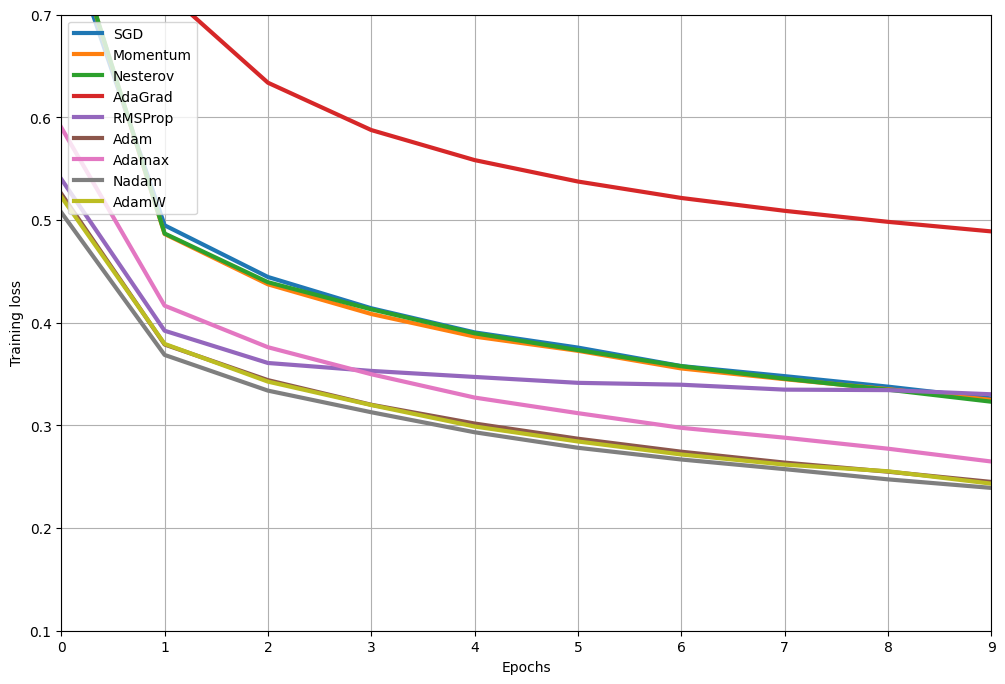

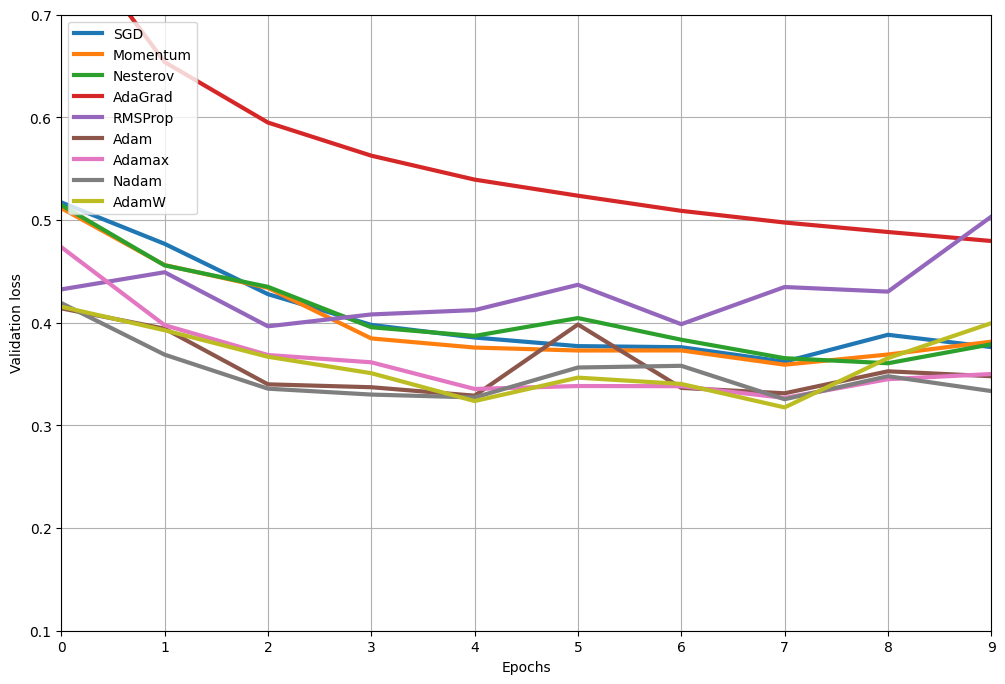

In [64]:
# Extra code to visualize the learning curves of all the optimizers

for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    optimizers_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, optimizer_name in zip(
        (
            history_sgd,
            history_momentum,
            history_nesterov,
            history_adagrad,
            history_rmsprop,
            history_adam,
            history_adamax,
            history_nadam,
            history_adamw,
        ),
        optimizers_names.split(),
    ):
        plt.plot(history.history[loss], label=f"{optimizer_name}", linewidth=3)

    plt.grid()
    plt.xlabel("Epochs")
    if loss == "loss":
        plt.ylabel("Training loss")
    if loss == "val_loss":
        plt.ylabel("Validation loss")
    plt.legend(loc="upper left")
    plt.axis([0, 9, 0.1, 0.7])
    plt.show()

## Learning Rate Scheduling

### Power Scheduling

```python
learning_rate = initial_learning_rate / (1 + step / decay_steps) ** power
```
Keras uses `power=1`.

**Note**: The `decay` argument in optimizers is deprecated. The old optimizers which implements the `decay` argument are still available in `tf.keras.optimizers.legacy`, but you should use the schedulers in `tf.keras.optimizers.schedules` instead.

In [65]:
# Deprecated:
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.01, decay=1e-4)

In [66]:
# Recommended
lr_scheduler = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.01, decay_steps=10_000, decay_rate=1.0, staircase=False
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_scheduler)

The `InverseTimeDecay` scheduler uses `learning_rate=initial_learning_rate / (1 + decay_rate * step / decay_steps)`. If you set `staircase=True`, then it replaces `step / decay_steps` with `floor(step / decay_steps)`.

In [67]:
history_power_scheduling = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.8243 - accuracy: 0.7294 - val_loss: 0.5160 - val_accuracy: 0.8186
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4984 - accuracy: 0.8241 - val_loss: 0.4696 - val_accuracy: 0.8280
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4466 - accuracy: 0.8415 - val_loss: 0.4342 - val_accuracy: 0.8490
Epoch 4/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4212 - accuracy: 0.8507 - val_loss: 0.4056 - val_accuracy: 0.8560
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4007 - accuracy: 0.8591 - val_loss: 0.4007 - val_accuracy: 0.8558
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3859 - accuracy: 0.8631 - val_loss: 0.4053 - val_accuracy: 0.8550
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3753 - accuracy: 0.8672 - val_loss: 0.3817 - val_accuracy:

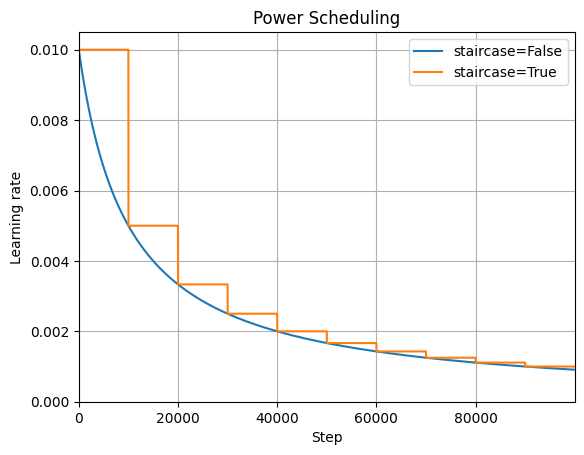

In [68]:
initial_learning_rate = 0.01
decay_rate = 1.0
decay_steps = 10_000

steps = np.arange(100_000)
lrs = initial_learning_rate / (1 + decay_rate * (steps / decay_steps))
lrs2 = initial_learning_rate / (1 + decay_rate * np.floor(steps / decay_steps))

plt.plot(steps, lrs, "-", label="staircase=False")
plt.plot(steps, lrs2, "-", label="staircase=True")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.title("Power Scheduling")
plt.legend()
plt.grid()
plt.show()

### Exponential Scheduling

`learning_rate = initial_learning_rate * decay_rate ** (step / decay_steps)`

In [69]:
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01, decay_steps=20_000, decay_rate=0.1, staircase=False
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_scheduler)

In [70]:
history_exponential_scheduling = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.7630 - accuracy: 0.7435 - val_loss: 0.5015 - val_accuracy: 0.8242
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4907 - accuracy: 0.8266 - val_loss: 0.4743 - val_accuracy: 0.8262
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4408 - accuracy: 0.8449 - val_loss: 0.4223 - val_accuracy: 0.8528
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4157 - accuracy: 0.8535 - val_loss: 0.4046 - val_accuracy: 0.8582
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3972 - accuracy: 0.8602 - val_loss: 0.3977 - val_accuracy: 0.8542
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3842 - accuracy: 0.8643 - val_loss: 0.3954 - val_accuracy: 0.8590
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3752 - accuracy: 0.8677 - val_loss: 0.3854 - val_accuracy:

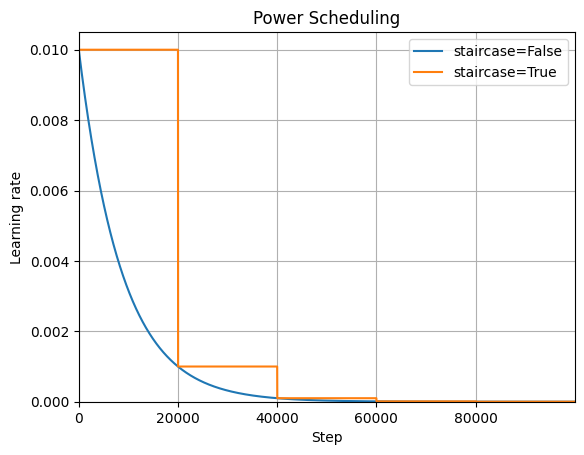

In [71]:
initial_learning_rate = 0.01
decay_rate = 0.1
decay_steps = 20_000

steps = np.arange(100_000)
lrs = initial_learning_rate * decay_rate ** (steps / decay_steps)
lrs2 = initial_learning_rate * decay_rate ** np.floor(steps / decay_steps)

plt.plot(steps, lrs, "-", label="staircase=False")
plt.plot(steps, lrs2, "-", label="staircase=True")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.title("Power Scheduling")
plt.legend()
plt.grid()
plt.show()

Keras also provides a `LearningRateScheduler` callback class that let you define your own scheduling function. Here is how you could use it to implement exponential decay. <br>
Not that in this case, the learning rate only changes at each epoch, not at each step.

In [72]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1 ** (epoch / 20)

In [73]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)

    return exponential_decay_fn


exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [ ]:
tf.random.set_seed(42)
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)

In [75]:
n_epochs = 20

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(
    X_train,
    y_train,
    epochs=n_epochs,
    validation_data=(X_valid, y_valid),
    callbacks=[lr_scheduler],
)

Epoch 1/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7429 - val_loss: 0.4080 - lr: 0.0100
Epoch 2/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3898 - val_loss: 0.3627 - lr: 0.0089
Epoch 3/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3550 - val_loss: 0.3505 - lr: 0.0079
Epoch 4/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3332 - val_loss: 0.3412 - lr: 0.0071
Epoch 5/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3201 - val_loss: 0.3338 - lr: 0.0063
Epoch 6/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3090 - val_loss: 0.3345 - lr: 0.0056
Epoch 7/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3001 - val_loss: 0.3284 - lr: 0.0050
Epoch 8/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2934 - val_loss: 0.3254 - lr: 0.0045
Epoch 9/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.28

Alternatively, the schedule function can take the current learning rate as a second argument.

In [76]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1 ** (1 / 20)

**Extra material**: if you want to use a custom scheduling function that updates the learning rate at each iteration rather than at each epoch, you can write your own callback class like this:

In [77]:
K = tf.keras.backend


class ExponentialDecay(tf.keras.callbacks.Callback):
    def __init__(self, n_steps):
        super().__init__()
        self.n_steps = n_steps

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at every epoch
        lr = K.get_value(self.model.optimizer.learning_rate)
        new_learning_rate = lr * 0.1 ** (1 / self.n_steps)
        K.set_value(self.model.optimizer.learning_rate, new_learning_rate)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs["lr"] = K.get_value(self.model.optimizer.learning_rate)

In [7]:
lr0 = 0.01
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)

In [79]:
import math

batch_size = 32
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
exp_decay = ExponentialDecay(n_steps)
history = model.fit(
    X_train,
    y_train,
    epochs=n_epochs,
    validation_data=(X_valid, y_valid),
    callbacks=[exp_decay],
)

Epoch 1/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.7588 - accuracy: 0.7454 - val_loss: 0.5011 - val_accuracy: 0.8244 - lr: 0.0089
Epoch 2/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4901 - accuracy: 0.8281 - val_loss: 0.4572 - val_accuracy: 0.8382 - lr: 0.0079
Epoch 3/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4389 - accuracy: 0.8439 - val_loss: 0.4249 - val_accuracy: 0.8516 - lr: 0.0071
Epoch 4/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4130 - accuracy: 0.8538 - val_loss: 0.3968 - val_accuracy: 0.8602 - lr: 0.0063
Epoch 5/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3921 - accuracy: 0.8596 - val_loss: 0.3861 - val_accuracy: 0.8600 - lr: 0.0056
Epoch 6/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3770 - accuracy: 0.8658 - val_loss: 0.3880 - val_accuracy: 0.8594 - lr: 0.0050
Epoch 7/20
1719/1719 [==============================] - 3s

### Piecewise Constant Scheduling

In [81]:
lr_scheduler = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[50_000, 80_000], values=[0.01, 0.005, 0.001]
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_scheduler)

In [82]:
history_piecewise_scheduling = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.7611 - accuracy: 0.7446 - val_loss: 0.5020 - val_accuracy: 0.8232
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4852 - accuracy: 0.8289 - val_loss: 0.4760 - val_accuracy: 0.8302
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4330 - accuracy: 0.8455 - val_loss: 0.4258 - val_accuracy: 0.8508
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4060 - accuracy: 0.8556 - val_loss: 0.3987 - val_accuracy: 0.8602
Epoch 5/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3840 - accuracy: 0.8633 - val_loss: 0.3872 - val_accuracy: 0.8618
Epoch 6/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3665 - accuracy: 0.8683 - val_loss: 0.3853 - val_accuracy: 0.8614
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3542 - accuracy: 0.8721 - val_loss: 0.3686 - val_accuracy:

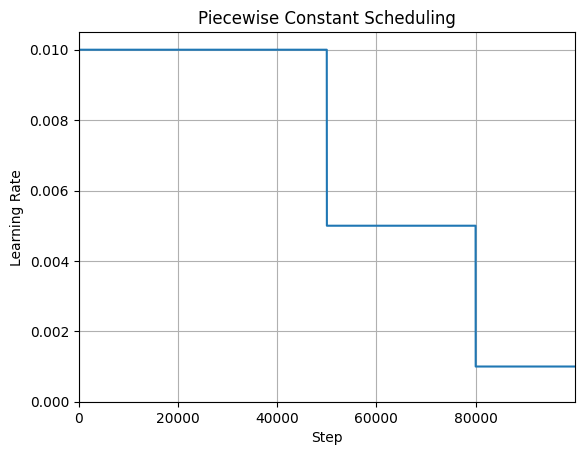

In [85]:
boundaries = [50_000, 80_000]
values = [0.01, 0.005, 0.001]

steps = np.arange(100_000)

lrs = np.full(len(steps), values[0])
for boundary, value in zip(boundaries, values[1:]):
    lrs[boundary:] = value

plt.plot(steps, lrs, "-")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling")
plt.grid()
plt.show()

Just like we did with exponential scheduling, we could also implement piecewise constant scheduling manually.

In [86]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    if epoch < 15:
        return 0.005
    else:
        return 0.001

In [89]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)

    def piecewise_constant_fn(epoch):
        return values[(boundaries > epoch).argmax() - 1]

    return piecewise_constant_fn


piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [90]:
# Extra code - use a tf.keras.callbacks.LearningRateScheduler as earlier

n_epochs = 25

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = build_model()
optimizer = tf.keras.optimizers.Nadam(learning_rate=lr0)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)
history = model.fit(
    X_train,
    y_train,
    epochs=n_epochs,
    validation_data=(X_valid, y_valid),
    callbacks=[lr_scheduler],
)

Epoch 1/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5456 - accuracy: 0.8088 - val_loss: 0.4646 - val_accuracy: 0.8388 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4521 - accuracy: 0.8419 - val_loss: 0.4501 - val_accuracy: 0.8418 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4283 - accuracy: 0.8497 - val_loss: 0.4367 - val_accuracy: 0.8466 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4294 - accuracy: 0.8522 - val_loss: 0.4173 - val_accuracy: 0.8596 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4070 - accuracy: 0.8592 - val_loss: 0.4215 - val_accuracy: 0.8562 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3599 - accuracy: 0.8727 - val_loss: 0.3854 - val_accuracy: 0.8618 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] - 4s

We've looked at `InverseTimeDecay`, `ExponentialDecay`, and `PiecewiseConstantDecay`. A few more schedulers are available in `tf.keras.optimizers.schedules`, here is the full list:

In [91]:
for name in sorted(dir(tf.keras.optimizers.schedules)):
    if name[0] == name[0].lower():  # must start with a capital letter
        continue
    scheduler_class = getattr(tf.keras.optimizers.schedules, name)
    print(f"- {name} - {scheduler_class.__doc__.splitlines()[0]}")

- CosineDecay - A LearningRateSchedule that uses a cosine decay with optional warmup.
- CosineDecayRestarts - A LearningRateSchedule that uses a cosine decay schedule with restarts.
- ExponentialDecay - A LearningRateSchedule that uses an exponential decay schedule.
- InverseTimeDecay - A LearningRateSchedule that uses an inverse time decay schedule.
- LearningRateSchedule - The learning rate schedule base class.
- PiecewiseConstantDecay - A LearningRateSchedule that uses a piecewise constant decay schedule.
- PolynomialDecay - A LearningRateSchedule that uses a polynomial decay schedule.


### Performance Scheduling

In [8]:
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)

In [10]:
n_epochs = 25

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
history = model.fit(
    X_train,
    y_train,
    epochs=n_epochs,
    validation_data=(X_valid, y_valid),
    callbacks=[lr_scheduler],
)

Epoch 1/25
1719/1719 [==============================] - 3s 1ms/step - loss: 0.8020 - accuracy: 0.7299 - val_loss: 0.4994 - val_accuracy: 0.8222 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4960 - accuracy: 0.8239 - val_loss: 0.4725 - val_accuracy: 0.8266 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4396 - accuracy: 0.8427 - val_loss: 0.4274 - val_accuracy: 0.8454 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4113 - accuracy: 0.8534 - val_loss: 0.3938 - val_accuracy: 0.8582 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3876 - accuracy: 0.8610 - val_loss: 0.3853 - val_accuracy: 0.8582 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3696 - accuracy: 0.8664 - val_loss: 0.3913 - val_accuracy: 0.8596 - lr: 0.0100
Epoch 7/25
1719/1719 [==============================] - 2s

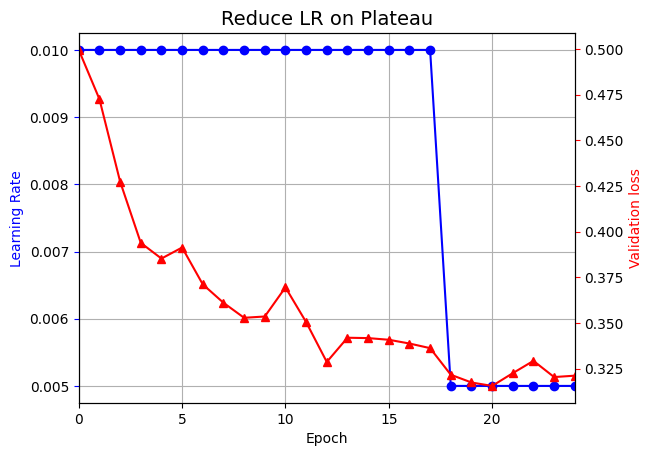

In [15]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color="b")
plt.tick_params("y", color="b")
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid()

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel("Validation loss", color="r")
ax2.tick_params("y", color="r")

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### 1Cycle Scheduling

- The `ExponentialLearningRate` custom callback updates the learning rate during training, at the end of each batch.
- It multiplies it by a constant `factor`.
- It also saves the learning rate and loss at each batch, each in a list.
- Since `log["loss"]` is actually the mean loss since the start of the epoch, anh we want to save the batch loss instead, we must compute the mean times the number of batches since the beginning of the epoch to get the total loss so far, then we subtract the total loss at the previous batch to get the current batch's loss.

In [6]:
K = tf.keras.backend


class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]  # the epoch's mean loss so far
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(batch_loss)
        K.set_value(
            self.model.optimizer.learning_rate,
            self.model.optimizer.learning_rate * self.factor,
        )

The `find_learning_rate()` function trains the model using the `ExponentialLearningRate` callback, and it returns the learning rates and the corresponding batch losses. At the end, it restores the model and its optimizer to their initial state.

In [13]:
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-4, max_rate=1):
    import math

    init_weights = model.get_weights()
    init_lr = K.get_value(model.optimizer.learning_rate)
    iterations = math.ceil(len(X_train) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1 / iterations)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size, callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

The `plot_lr_vs_loss()` function plots the learning rates vs the losses. The optimal learning rate to use as the maximum learning rate in 1cycle is near the bottom of the curve.

In [8]:
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale("log")
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), colors="k")
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.grid()

In [9]:
model = build_model()
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    metrics=["accuracy"],
)

Now, let's find the optimal learning rate for 1cycle: 

430/430 [==============================] - 2s 3ms/step - loss: 7.1215 - accuracy: 0.3078


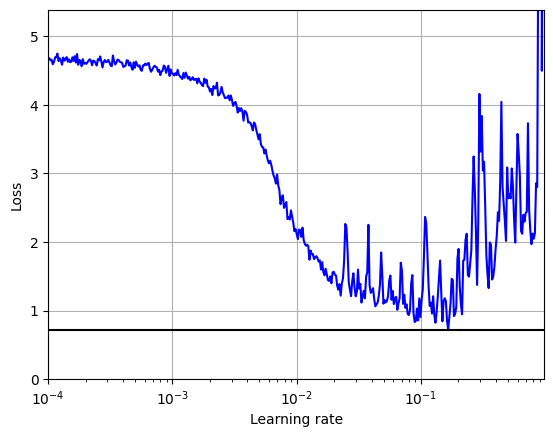

In [14]:
batch_size = 128
rates, losses = find_learning_rate(
    model, X_train, y_train, epochs=1, batch_size=batch_size
)
plot_lr_vs_loss(rates, losses)

Looks like the optimal learning rate to use for 1cycle is about 0.1.

In [16]:
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(
        self, iterations, max_lr=1e-3, start_lr=None, last_iterations=None, last_lr=None
    ):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iterations = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1: int, iter2: int, lr1: int, lr2: int):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs=None):
        if self.iteration < self.half_iterations:
            lr = self._interpolate(0, self.half_iterations, self.start_lr, self.max_lr)
        elif self.iteration < 2 * self.half_iterations:
            lr = self._interpolate(
                self.half_iterations,
                2 * self.half_iterations,
                self.max_lr,
                self.start_lr,
            )
        else:
            lr = self._interpolate(
                2 * self.half_iterations, self.iterations, self.max_lr, self.last_lr
            )
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, lr)

Here we build and compile a simple Fashion MNIST model, then train it using the `OneCycleScheduler` callback.

In [18]:
import math

model = build_model()
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.SGD(),
    metrics=["accuracy"],
)
n_epochs = 25
one_cycle = OneCycleScheduler(
    math.ceil(len(X_train) / batch_size) * n_epochs, max_lr=0.1
)
history = model.fit(
    X_train,
    y_train,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_data=(X_valid, y_valid),
    callbacks=[one_cycle],
)

Epoch 1/25
430/430 [==============================] - 2s 4ms/step - loss: 1.2201 - accuracy: 0.6319 - val_loss: 0.6529 - val_accuracy: 0.7756
Epoch 2/25
430/430 [==============================] - 1s 3ms/step - loss: 0.6314 - accuracy: 0.7789 - val_loss: 0.5265 - val_accuracy: 0.8124
Epoch 3/25
430/430 [==============================] - 1s 3ms/step - loss: 0.5277 - accuracy: 0.8127 - val_loss: 0.4756 - val_accuracy: 0.8326
Epoch 4/25
430/430 [==============================] - 1s 3ms/step - loss: 0.4717 - accuracy: 0.8319 - val_loss: 0.4612 - val_accuracy: 0.8380
Epoch 5/25
430/430 [==============================] - 1s 3ms/step - loss: 0.4393 - accuracy: 0.8415 - val_loss: 0.4449 - val_accuracy: 0.8376
Epoch 6/25
430/430 [==============================] - 1s 3ms/step - loss: 0.4125 - accuracy: 0.8526 - val_loss: 0.5379 - val_accuracy: 0.8040
Epoch 7/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3972 - accuracy: 0.8566 - val_loss: 0.4114 - val_accuracy: 0.8526
Epoch 

# Avoiding Overfitting Through Regularization

In [3]:
layer = tf.keras.layers.Dense(
    100,
    activation="relu",
    kernel_initializer="he_normal",
    kernel_regularizer=tf.keras.regularizers.l2(0.01),
)

or use `l1(0.1)` for $\ell_1$ regularization with a factor of 0.1, or use `l1_l2(0.1, 0.01)` for both $\ell_1$ and $ell_2$, with factors 0.1 and 0.01, respectively.

In [4]:
tf.random.set_seed(42)

In [5]:
from functools import partial

RegularizedDense = partial(
    tf.keras.layers.Dense,
    activation="relu",
    kernel_initializer="he_normal",
    kernel_regularizer=tf.keras.regularizers.l2(0.01),
)

model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        RegularizedDense(100),
        RegularizedDense(100),
        RegularizedDense(10, activation="softmax"),
    ]
)

In [11]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.02)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)
history = model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 2s 1ms/step - loss: 0.8592 - accuracy: 0.8188 - val_loss: 0.8473 - val_accuracy: 0.8232
Epoch 2/2
1719/1719 [==============================] - 2s 1ms/step - loss: 0.8578 - accuracy: 0.8194 - val_loss: 0.8479 - val_accuracy: 0.8228


## Dropout

In [12]:
tf.random.set_seed(42)

In [15]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)

In [16]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6749 - accuracy: 0.7529 - val_loss: 0.4610 - val_accuracy: 0.8248
Epoch 2/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.5096 - accuracy: 0.8152 - val_loss: 0.4176 - val_accuracy: 0.8430
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4748 - accuracy: 0.8288 - val_loss: 0.3852 - val_accuracy: 0.8566
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4471 - accuracy: 0.8361 - val_loss: 0.3890 - val_accuracy: 0.8538
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4346 - accuracy: 0.8411 - val_loss: 0.3660 - val_accuracy: 0.8620
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4227 - accuracy: 0.8443 - val_loss: 0.3661 - val_accuracy: 0.8664
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4138 - accuracy: 0.8478 - val_loss: 0.3724 - val_accuracy:

- The training accuracy looks like it's lower than the validation accuracy, but that's just because dropout is only active during training.
- If we evaluate the model on the training set after training (e.g., with dropout turned off), we get the "real" training accuracy, which is very slightly higher than the validation accuracy and the test accuracy.

In [17]:
model.evaluate(X_train, y_train)

1719/1719 [==============================] - 2s 891us/step - loss: 0.3127 - accuracy: 0.8821


[0.31274792551994324, 0.8820909261703491]

In [18]:
model.evaluate(X_test, y_test)

  1/313 [..............................] - ETA: 4s - loss: 0.3906 - accuracy: 0.8750

313/313 [==============================] - 0s 920us/step - loss: 0.3681 - accuracy: 0.8655


[0.3681333661079407, 0.8654999732971191]

**Note**: Make sure to use `AlphaDropout` instead of `Dropout` if you want to build a self-normalizing neural network using SELU.

## MC Dropout

In [21]:
tf.random.set_seed(42)

In [22]:
y_probas = np.stack([model(X_test, training=True) for sample in range(100)])
y_proba = y_probas.mean(axis=0)

In [23]:
model.predict(X_test[:1]).round(3)

1/1 [==============================] - 0s 22ms/step


array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.014, 0.   , 0.181, 0.   ,
        0.805]], dtype=float32)

In [24]:
y_proba[0].round(3)

array([0.   , 0.001, 0.001, 0.001, 0.001, 0.049, 0.001, 0.242, 0.001,
       0.702], dtype=float32)

In [25]:
y_std = y_probas.std(axis=0)
y_std[0].round(3)

array([0.001, 0.003, 0.007, 0.003, 0.008, 0.074, 0.008, 0.159, 0.004,
       0.186], dtype=float32)

In [26]:
y_predict = y_proba.argmax(axis=1)
accuracy = (y_predict == y_test).sum() / len(y_test)
accuracy

0.8654

In [27]:
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

In [28]:
# Extra code - shows how to convert Dropout to MCDropout in a Sequential model
Dropout = tf.keras.layers.Dropout
mc_model = tf.keras.Sequential(
    [
        MCDropout(layer.rate) if isinstance(layer, Dropout) else layer
        for layer in model.layers
    ]
)
mc_model.set_weights(model.get_weights())

In [33]:
mc_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 mc_dropout (MCDropout)      (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 100)               78500     
                                                                 
 mc_dropout_1 (MCDropout)    (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 mc_dropout_2 (MCDropout)    (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 10)               

Now we can use the model with MC dropout.

In [34]:
# Extra code showing the model works without retraining
tf.random.set_seed(42)
np.mean([mc_model.predict(X_test[:1]) for sample in range(100)], axis=0).round(2)

1/1 [==============================] - 0s 11ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.25, 0.  , 0.71]],
      dtype=float32)